<a href="https://colab.research.google.com/github/ChloeMorgana/DL-Coursework/blob/main/2439047s_DL_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Student Number: 2439047s

### Various Imports 

In [63]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import collections
#!pip install --upgrade scikit-learn
#from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn import metrics

# Loading the data
# we will use wget to get the archive
!wget --no-check-certificate "https://www.dropbox.com/s/v2udcnt98miwwrq/plankton.pt?dl=1" -O plankton.pt

--2023-03-14 10:00:45--  https://www.dropbox.com/s/v2udcnt98miwwrq/plankton.pt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/v2udcnt98miwwrq/plankton.pt [following]
--2023-03-14 10:00:45--  https://www.dropbox.com/s/dl/v2udcnt98miwwrq/plankton.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb59146b884bdf7d63e8acbc5f7.dl.dropboxusercontent.com/cd/0/get/B4Nsid9nIcjf4IAF870ItasJQi5jhJhuv4JQqOAEROgktrlxy0e73UxMOPpZ4LsQ9zfp3qo_PSCOk5x1nKW7BULfuS9wVq-qCLgOU5MOkBEfgFQNGTW_zSMt3UK52hXfqfxWqBhAymFMV_AQ1MG-kO7NmaHsmwJTG3bdvVyxUgH0gw/file?dl=1# [following]
--2023-03-14 10:00:46--  https://ucb59146b884bdf7d63e8acbc5f7.dl.dropboxusercontent.com/cd/0/get/B4Nsid9nIcjf4IAF870ItasJQi5jhJhuv4JQqOAEROgktrlxy0e73UxMOPpZ4LsQ9zfp3qo_PSCOk5

# Plankton Data

There are 12 classes of plankton that need to be classified. It can be observed that there are significantly more examples of particular species of plankton compared to others within the dataset. For example, class 2.0 has 257 examples and class 1.0 only has 65 examples. This class imbalance has the potential to reduce classification performance, since the network learns less from classes with smaller instances, and is therefore less likely to correctly predict instances within the test set. It is likely that data augmentation will have to be performed later on to reduce this issue.

In [180]:
data = torch.load('plankton.pt')
#print(data['images'])

#get the number of different classes
classes = data['labels'].unique()
nclasses = len(classes)
print('The classes in this dataset are: ')
print(classes)

#display the number of instances per class: 
print('\nAnd the numbers of examples per class are: ')
print( pd.Series(data['labels']).value_counts() )

The classes in this dataset are: 
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

And the numbers of examples per class are: 
2.0     257
8.0     235
7.0     219
10.0    157
11.0    135
0.0     134
3.0     110
6.0      92
9.0      76
4.0      70
5.0      67
1.0      65
dtype: int64


# Loading the data

I chose to split the data into train, validation and test sets, with 60% in the training set, 20% in the validation set and 20% in the test set. This ensures that there is enough data to train on to increase the likelihood of being able to generalise well to new data, in addition to having sufficient validation data to get a reliable estimate of model performance.

In [ ]:
train, test, train_labs, test_labs = train_test_split(data['images'], data['labels'], test_size=0.2, random_state=42)

train, val, train_labs, val_labs = train_test_split(train, train_labs, test_size=0.25, random_state=42)

I then created an ImageDataset class that inherits from Pytorch's Dataset class to store the samples and corresponding lables, and using DataLoader to iterate through these samples. Initially, there is no data augmentation involved, however this will be used later on to observe the effect. Consequently there is an additional argument that can be passed in to apply transformations to the data.

In [204]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label


# Architecture

I decided to go for a Convolutional Neural Network (CNN) for this task, since it is able to automatically learn relevant features from the raw pixel values of images, without the need for manual feature engineering. There is a balance when it comes to the number of layers needed for this particular task - Too few layers and the model won't pick up certain features contained in the images that would be crucial for being able to classify them as a particular type of plankton, whereas too many layers can cause extensive training times and features that are too complex. I decided to go for a simple model with 6 layers, in order to observe its initial effectiveness and potentially build on it as results are obtained.

In [190]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(7744, 120) #Normal
        #self.fc1 = nn.Linear(35344, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 12)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Training

The loss function I've chosen is cross entropy loss, since it can measure the distance between the predicted and true probability distributions and therefore penalise the model for making incorrect predictions. It can also accommodate the complexity of multi-class classification and compute the loss for each class independently.

I have chosen stochastic gradient descent as the optimiser, since it is typically more efficient than other optimisers, and is less likely to get trapped in local minima. It can also be easily adapted to training models with a variety of configurations.

A training function is defined so that different hyperparameters can be inputted. It keeps track of both training and validation losses to ensure that they are both reducing after each iteration, which ensures that the model is learning more from the data after every pass.

In [201]:
import torch.optim as optim

def training(lr, momentum, epoch=40, loader=train_loader, network=net):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=lr, momentum=momentum)
    #print(net.parameters())

    train_losses = []
    val_losses = []

    for e in range(epoch):  
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(loader):
            inputs, labels = data
            labels = labels.long()

            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()

            # Update loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss and accuracy for epoch
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total

        # Evaluate on validation set
        network.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                labels = labels.long()
                outputs = network(inputs)
                val_loss += criterion(outputs, labels).item()
                val_losses.append(val_loss)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy for epoch
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total

        # Print metrics for epoch
        if e%5==0:
            print(f'Epoch {e+1}/{epoch}: Train Loss: {epoch_train_loss:.3f}, Train Acc: {epoch_train_acc:.2f}%, Val Loss: {epoch_val_loss:.3f}, Val Acc: {epoch_val_acc:.2f}%')

    print('Finished Training')

    return train_losses, val_losses

An evaluation function is then defined that displays the confusion matrix

In [202]:
from sklearn.metrics import classification_report

def evaluate(loader=test_loader, network=net):
    correct = 0
    total = 0
    preds = []
    labs = []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = network(images)

            _, predicted = torch.max(outputs.data, 1)
            labs+=labels.tolist()
            preds+=predicted.tolist()
    #print(labs)
    #print(preds)

    confusion_matrix = metrics.confusion_matrix(labs, preds)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

    cm_display.plot()
    plt.show()

    print(classification_report(labs, preds))

The initial hyperparameters chosen for the model were a batch size of 32, a learning rate of 0.01 and a momentum value of 0.1. It can be observed by the results that in this state, the classifier is not very effective at correctly predicting each species of plankton.

Epoch 1/40: Train Loss: 2.477, Train Acc: 14.14%, Val Loss: 2.472, Val Acc: 12.35%
Epoch 6/40: Train Loss: 1.775, Train Acc: 33.64%, Val Loss: 1.804, Val Acc: 37.65%
Epoch 11/40: Train Loss: 1.552, Train Acc: 38.08%, Val Loss: 1.560, Val Acc: 45.37%
Epoch 16/40: Train Loss: 1.457, Train Acc: 43.24%, Val Loss: 1.628, Val Acc: 42.59%
Epoch 21/40: Train Loss: 1.373, Train Acc: 46.13%, Val Loss: 1.492, Val Acc: 44.75%
Epoch 26/40: Train Loss: 1.322, Train Acc: 46.65%, Val Loss: 1.615, Val Acc: 46.91%
Epoch 31/40: Train Loss: 1.265, Train Acc: 47.78%, Val Loss: 1.201, Val Acc: 55.25%
Epoch 36/40: Train Loss: 1.226, Train Acc: 50.98%, Val Loss: 1.391, Val Acc: 49.69%
Finished Training


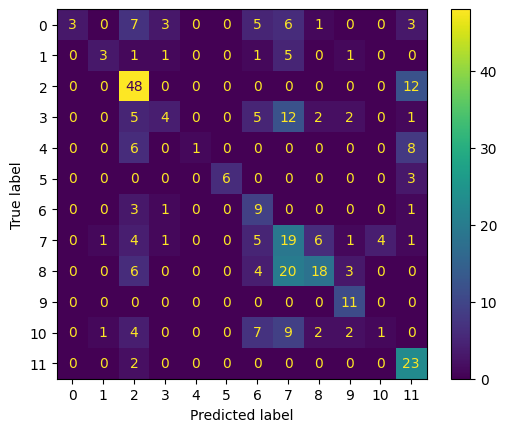

              precision    recall  f1-score   support

         0.0       1.00      0.11      0.19        28
         1.0       0.60      0.25      0.35        12
         2.0       0.56      0.80      0.66        60
         3.0       0.40      0.13      0.20        31
         4.0       1.00      0.07      0.12        15
         5.0       1.00      0.67      0.80         9
         6.0       0.25      0.64      0.36        14
         7.0       0.27      0.45      0.34        42
         8.0       0.62      0.35      0.45        51
         9.0       0.55      1.00      0.71        11
        10.0       0.20      0.04      0.06        26
        11.0       0.44      0.92      0.60        25

    accuracy                           0.45       324
   macro avg       0.57      0.45      0.40       324
weighted avg       0.54      0.45      0.40       324



In [203]:
train_data = ImageDataset(train, train_labs)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

val_data = ImageDataset(val, val_labs)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

test_data = ImageDataset(test, test_labs)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

net = Net()
train_losses, val_losses = training(0.01,0.1, network = net)
    
evaluate(network = net)

# Grid Search

I performed grid search in order to find optimal hyperparameters to train the model. This involved testing different values for learning rate, batch size and momentum. The learning rate determines how quickly the model adjusts parameters during training and has significant impact on the performance of the model. If the value is high, then it can increase the convergence speed, but also risks overshooting the optimal solution and causing divergence. However if the value is too low, then the convergence rate would decrease and significantly increase the training time, in addition to increasing the likelihood of the model getting stuck in local minima.

Momentum helps to smooth out the optimisation process and reduce the impact of local minima during training. Similarly to the learning rate, increasing this value can result in faster convergence and accuracy, but also risks overshooting the minimum.

The batch size determines how many samples are used in each iteration during optimization. Increasing this value can result in faster convergence but worse generalisation, and vice versa for smaller batch sizes.

These hyperparameter values can all affect each other, so grid search was chosen in order to find the best combination.

The best hyperparameters were:
* Learning rate: 0.01
* Momentum: 0.5
* Batch size: 16

In [75]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV

class PyTorchEstimator(BaseEstimator):
    def __init__(self, net, criterion, optimizer, batch_size,lr,momentum):
        self.net = net
        self.criterion = criterion
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.lr = lr
        self.momentum = momentum

    def fit(self, X, y):
        self.optimizer = torch.optim.SGD(self.net.parameters(), lr=self.lr, momentum=self.momentum)
        for epoch in range(40):
            train_data = ImageDataset(X, y)
            train_loader = DataLoader(train_data, batch_size=self.batch_size)
            for i, data in enumerate(train_loader):
                inputs, labels = data
                labels = labels.long()
                self.optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

    def predict(self, X):
      with torch.no_grad():
        outputs = self.net(X)
        probabilities, predicted_classes = torch.max(outputs, dim=1)
      return predicted_classes

# Define the hyperparameters to search over
param_grid = {
    'lr': [0.001, 0.01, 0.1, 1.0],
    'momentum': [0.1, 0.5, 0.9],
    'batch_size': [16, 32, 64, 128]
}

# Define the PyTorch model, criterion, optimizer, and data loaders
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Create the PyTorchEstimator object and the GridSearchCV object
estimator = PyTorchEstimator(net, criterion, optimizer, batch_size=32, lr=0.001, momentum=0.9)
gs = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')

# Fit the GridSearchCV object to the data
gs.fit(train, train_labs)

# Print the best hyperparameters
print("Best hyperparameters: ", gs.best_params_)

# Evaluate the best model on the test set
best_net = gs.best_estimator_.net
test_loss = 0.0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        labels = labels.long()
        outputs = best_net(inputs)
        test_loss += criterion(outputs, labels).item()

test_loss /= len(test_loader)
print("Test loss: ", test_loss)


Best hyperparameters:  {'batch_size': 16, 'lr': 0.01, 'momentum': 0.5}
Test loss:  2.0121612548828125


# Results

Using the parameters found from grid search, this F1-score of the model has appeared to have increased by around 10% for the test set, emphasising that tuning these hyperparameters has resulted in an improvement of the initial model. The confusion matrix below shows there are more entries in the main diagonal comapared to the pervious model. 

Further observation of the confusion matrix confirms that the model is more likely to struggle with classes with fewer instances in the training set. For example, the majority of instances for class 2 and class 8 have been correctly predicted, whilst there are fewer entries correctly predicted for the rest of the classes. The results could potentially be improved by providing the model with additional training data.

Epoch 1/40: Train Loss: 1.261, Train Acc: 10.01%, Val Loss: 2.460, Val Acc: 22.84%
Epoch 6/40: Train Loss: 0.843, Train Acc: 36.22%, Val Loss: 1.599, Val Acc: 36.42%
Epoch 11/40: Train Loss: 0.754, Train Acc: 42.41%, Val Loss: 1.400, Val Acc: 43.83%
Epoch 16/40: Train Loss: 0.682, Train Acc: 46.13%, Val Loss: 1.263, Val Acc: 50.00%
Epoch 21/40: Train Loss: 0.633, Train Acc: 51.08%, Val Loss: 1.199, Val Acc: 54.63%
Epoch 26/40: Train Loss: 0.583, Train Acc: 55.73%, Val Loss: 1.199, Val Acc: 53.09%
Epoch 31/40: Train Loss: 0.532, Train Acc: 58.82%, Val Loss: 1.288, Val Acc: 53.70%
Epoch 36/40: Train Loss: 0.477, Train Acc: 63.98%, Val Loss: 1.203, Val Acc: 57.72%
Finished Training


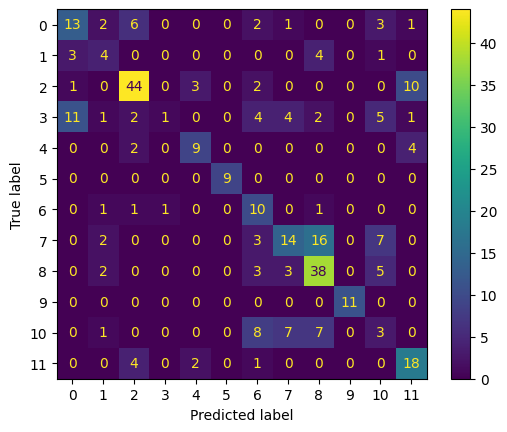

              precision    recall  f1-score   support

         0.0       0.46      0.46      0.46        28
         1.0       0.31      0.33      0.32        12
         2.0       0.75      0.73      0.74        60
         3.0       0.50      0.03      0.06        31
         4.0       0.64      0.60      0.62        15
         5.0       1.00      1.00      1.00         9
         6.0       0.30      0.71      0.43        14
         7.0       0.48      0.33      0.39        42
         8.0       0.56      0.75      0.64        51
         9.0       1.00      1.00      1.00        11
        10.0       0.12      0.12      0.12        26
        11.0       0.53      0.72      0.61        25

    accuracy                           0.54       324
   macro avg       0.55      0.57      0.53       324
weighted avg       0.54      0.54      0.51       324



In [188]:
train_data = ImageDataset(train, train_labs)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

val_data = ImageDataset(val, val_labs)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)

test_data = ImageDataset(test, test_labs)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)
net = Net()
training(0.01,0.5, network=net)
evaluate(network=net)

# Data Augmentation

There can now be an investigation into how data can be augmented in order for provide more information to the model. Different transformations will be applied to the data, and then added to the existing dataset in order to create more instances for each class. The data can be flipped horizontally and rotated to add more variety to the input data. These can then be added to each dataset so that there are more instances for the classifier to train on.

In [220]:
flip = transforms.RandomHorizontalFlip() # randomly flip the image horizontally
rot = transforms.RandomRotation(30) # randomly rotate the image by up to 30 degrees

#Flipped training data
flip_train_data = ImageDataset(train, train_labs, flip)
rot_train_data = ImageDataset(train, train_labs, rot)
tran_train_loader = DataLoader(train_data+flip_train_data+rot_train_data, batch_size=16, shuffle=True)

#Rotated training data
flip_val_data = ImageDataset(val, val_labs, flip)
rot_val_data = ImageDataset(val, val_labs, rot)
tran_val_loader = DataLoader(val_data+flip_val_data+rot_val_data, batch_size=16, shuffle=True)

# Combined augmented data and original
flip_test_data = ImageDataset(test, test_labs, flip)
rot_test_data = ImageDataset(test, test_labs, rot)
tran_test_loader = DataLoader(test_data+flip_test_data+rot_test_data, batch_size=16, shuffle=True)

It can be observed that adding more data to the model has improved the overall F1-Score on the test data. This is likely due to the model being able to learn more patterns from the data in order to correctly classify them.

Epoch 1/40: Train Loss: 6.182, Train Acc: 27.97%, Val Loss: 1.811, Val Acc: 31.17%
Epoch 6/40: Train Loss: 3.898, Train Acc: 48.95%, Val Loss: 1.181, Val Acc: 53.09%
Epoch 11/40: Train Loss: 2.954, Train Acc: 61.95%, Val Loss: 1.110, Val Acc: 57.41%
Epoch 16/40: Train Loss: 2.242, Train Acc: 70.55%, Val Loss: 1.095, Val Acc: 64.81%
Epoch 21/40: Train Loss: 1.694, Train Acc: 77.98%, Val Loss: 1.025, Val Acc: 66.05%
Epoch 26/40: Train Loss: 1.304, Train Acc: 82.94%, Val Loss: 1.089, Val Acc: 66.36%
Epoch 31/40: Train Loss: 1.057, Train Acc: 85.90%, Val Loss: 1.250, Val Acc: 66.67%
Epoch 36/40: Train Loss: 0.881, Train Acc: 87.99%, Val Loss: 1.379, Val Acc: 66.67%
Finished Training


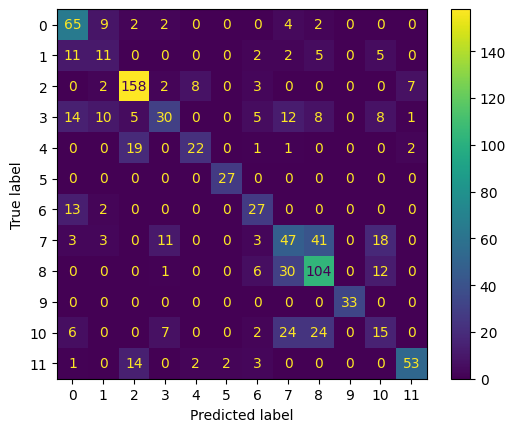

              precision    recall  f1-score   support

         0.0       0.58      0.77      0.66        84
         1.0       0.30      0.31      0.30        36
         2.0       0.80      0.88      0.84       180
         3.0       0.57      0.32      0.41        93
         4.0       0.69      0.49      0.57        45
         5.0       0.93      1.00      0.96        27
         6.0       0.52      0.64      0.57        42
         7.0       0.39      0.37      0.38       126
         8.0       0.57      0.68      0.62       153
         9.0       1.00      1.00      1.00        33
        10.0       0.26      0.19      0.22        78
        11.0       0.84      0.71      0.77        75

    accuracy                           0.61       972
   macro avg       0.62      0.61      0.61       972
weighted avg       0.60      0.61      0.60       972



In [121]:
net = Net()
training(0.01,0.5,loader=tran_train_loader, network=net)
evaluate(loader=tran_test_loader, network=net)

# Creating a more Complex Model

There could be a benefit with adding an additional convolutional layer within the network. By adding an additional convolutional layer, the model could be able to learn more complex features in the images. This can be particularly helpful when working with images that have a lot of variation or detail, such as plankton images. The additional layer could allow the model to learn more intricate patterns and structures in the images, and lead to improved accuracy.

In [221]:
class CompNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5) # additional convolutional layer
        self.fc1 = nn.Linear(10368, 120) # adjust input size of first fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 12)

    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = F.relu(self.conv3(x)) # additional convolutional layer
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.relu(self.fc2(x))
        #print(x.shape)
        x = self.fc3(x)
        #print(x.shape)
        return x


It can be observed that using both data augmentation techniques and using a more complex neural network has provided the best results for this task.

Epoch 1/40: Train Loss: 13.341, Train Acc: 19.30%, Val Loss: 1.928, Val Acc: 27.78%
Epoch 6/40: Train Loss: 7.492, Train Acc: 49.43%, Val Loss: 1.196, Val Acc: 54.63%
Epoch 11/40: Train Loss: 5.789, Train Acc: 62.06%, Val Loss: 1.139, Val Acc: 57.72%
Epoch 16/40: Train Loss: 4.673, Train Acc: 68.59%, Val Loss: 1.249, Val Acc: 63.27%
Epoch 21/40: Train Loss: 3.687, Train Acc: 75.23%, Val Loss: 1.346, Val Acc: 62.96%
Epoch 26/40: Train Loss: 3.052, Train Acc: 79.74%, Val Loss: 1.471, Val Acc: 58.95%
Epoch 31/40: Train Loss: 2.424, Train Acc: 83.87%, Val Loss: 1.464, Val Acc: 64.81%
Epoch 36/40: Train Loss: 1.996, Train Acc: 86.31%, Val Loss: 1.623, Val Acc: 64.51%
Finished Training


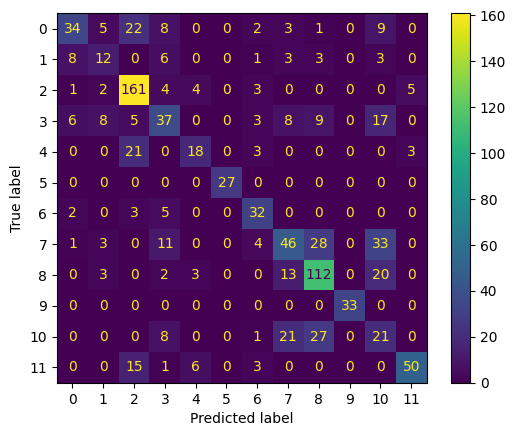

              precision    recall  f1-score   support

         0.0       0.65      0.40      0.50        84
         1.0       0.36      0.33      0.35        36
         2.0       0.71      0.89      0.79       180
         3.0       0.45      0.40      0.42        93
         4.0       0.58      0.40      0.47        45
         5.0       1.00      1.00      1.00        27
         6.0       0.62      0.76      0.68        42
         7.0       0.49      0.37      0.42       126
         8.0       0.62      0.73      0.67       153
         9.0       1.00      1.00      1.00        33
        10.0       0.20      0.27      0.23        78
        11.0       0.86      0.67      0.75        75

    accuracy                           0.60       972
   macro avg       0.63      0.60      0.61       972
weighted avg       0.60      0.60      0.59       972



In [222]:
complex_net = CompNet()
training(0.01,0.5,loader=tran_train_loader, network=complex_net)
evaluate(tran_test_loader, network=complex_net)

# Future Work

Finding optimal hyperparameters, augmenting the data and using a slightly more complex model have all incrementally improved the F1-Score for classifying plankton. However, there are still improvements that could be made in the future. It can be observed that classes 7.0, 8.0 and 10.0 are all often mistaken for one another. Having a look at some examples for each class, it is understandable as to why this is the case, since each species of plankton look quite similar. A potential solution for this would be to perform further data augmentation to emphasise their unique characteristics, such as changing the colour saturation or enlarging the images. These can be used in conjunction with an even more complex model containing more convolutional layers to pick up additional data features. More examples specific to these classes can also be added, so that they are considered equally during training.

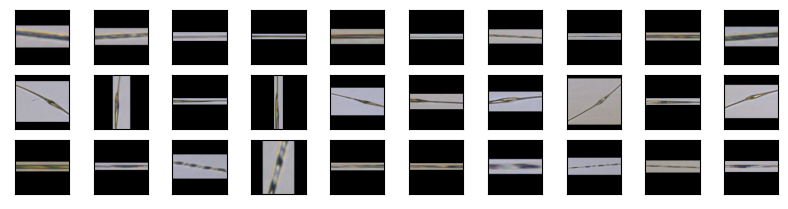

In [175]:
classes = data['labels'].unique()
fig = plt.figure(figsize=(10,10))
c = [7,8,10]
n = 10 # number of examples to show per class
for i in range(len(c)): 
  idx = data['labels'] == classes[c[i]]
  imgs = data['images'][idx,...]
  for j in range(n):
    ax = plt.subplot(12,n,i*n+j+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow( imgs[j,...].permute(1, 2, 0) ) # note the permute because tensorflow puts the channel as the first dimension whereas matplotlib expects WxHx3
plt.show()